1. Load and clean the data

In [12]:
!unzip /content/datasets/austinreese/craigslist-carstrucks-data/craigslist-carstrucks-data.zip

Archive:  /content/datasets/austinreese/craigslist-carstrucks-data/craigslist-carstrucks-data.zip
  inflating: vehicles.csv            


In [1]:
data_dir = '/content/vehicles.csv'
import pandas as pd
df = pd.read_csv(data_dir)

In [4]:
# df.head()
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [2]:
import code_cleaning as hf

import os
import matplotlib.pyplot as plt
import numpy as np

columns = ["id", "image_url", "VIN", "region_url", "id", "size","url"]
df.drop(columns, axis=1, inplace=True)

df = hf.imputeManufacturer(df)


In [3]:
df.fillna(value={'description': ''}, inplace=True)
df = hf.imputeMissingByManufacturer(df, col='fuel')
df = hf.imputeMissingByManufacturer(df, col='transmission')
df = hf.imputeOdometerByYear(df)
df = df[df['year'].notna()]
df = hf.color_clean(df, color_list=['white','black','silver'])
df = hf.drive_clean(df)
df = hf.transmission_clean(df)
df = hf.titlestatus_clean(df)
df = hf.cleanLocationFeatures(df)
df["cylinders"] = df["cylinders"].fillna("missing")
df, _ = hf.cutIQR(df, 'odometer')
df, _ = hf.cutIQR(df, 'price')
df = hf.cylinder_clean(df)
df = hf.condition_clean(df)
df = hf.fuel_clean(df)
df = hf.ohe_type(df)
df = hf.ohe_manuf_country(df)

Remove outliers...
Remove outliers...


In [5]:
df = hf.TF_IDF(df, number = 1000)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
df.columns

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'odometer',
       'type', 'description', 'county', 'lat',
       ...
       'manuf_country_missing', 'tfidf_0', 'tfidf_1', 'tfidf_2', 'tfidf_4',
       'tfidf_5', 'tfidf_6', 'tfidf_7', 'tfidf_8', 'tfidf_9'],
      dtype='object', length=109)

In [7]:
df.drop(['model', "manufacturer", "county", "type", "description"], axis=1, inplace=True)

In [13]:
df = df[df['year'].notna()]
df_processed = df.dropna()

In [20]:
df_processed.to_csv('/content/tidyData.csv')

2. data prep

In [21]:
import sklearn

# split data 7/2/1

y = df_processed.pop("price")
X = df_processed

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.33)
print("train set: %d, validation: %d, test: %d"%(
    X_train.shape[0],
    X_val.shape[0],
    X_test.shape[0]))

train set: 297398, validation: 85396, test: 42061


3. KNN training

In [26]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [29]:
# performance testing on val set
yhat_val = neigh.predict(X_val)
rmse = (yhat_val - y_val) ** 2 
rmse = rmse.mean() ** 0.5
print(rmse)

9398.697958198956


8739.962392434412
8773.515171033376
8973.012978518533
9398.697958198956


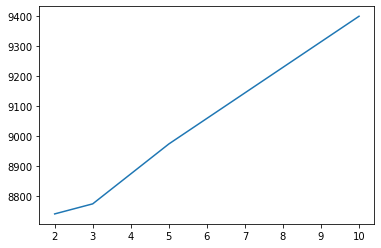

In [32]:
# influence of k
rmse_series=[]
k_series = [2, 3, 5,10]
for k in k_series:
  neigh = KNeighborsRegressor(n_neighbors=k)
  neigh.fit(X_train, y_train)
  yhat_val = neigh.predict(X_val)
  rmse = (yhat_val - y_val) ** 2 
  rmse = rmse.mean() ** 0.5
  rmse_series.append(rmse)
  print(rmse)

plt.plot(k_series, rmse_series)

an "elbow" shows up when k=3, so choose k=3 and further test on the test set

In [33]:
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train, y_train)
yhat_test = neigh.predict(X_test)
rmse = (yhat_test - y_test) ** 2 
rmse = rmse.mean() ** 0.5
print(rmse)

8840.573293800075
